# Assignment 4 - Model Fitting and Local Optimization
**Author:** Johannes Holmgren

In [38]:
# Import external modules
# Uncomment below to have interactive 3D models
# %matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.linalg import null_space, inv, qr
import cv2
from skimage import transform

# Import internal modules/files
import plotter
import utils

In [39]:
# ----- Constants -----
MAT_PATH = 'data/mat/'      # Path to data
IMG_PATH = 'data/images/'   # Path to images
# ---------------------

The RMS is 155.9583 (not robust)
The robust essential matrix has 5805 inliers
The RMS is 209.8 (robust)


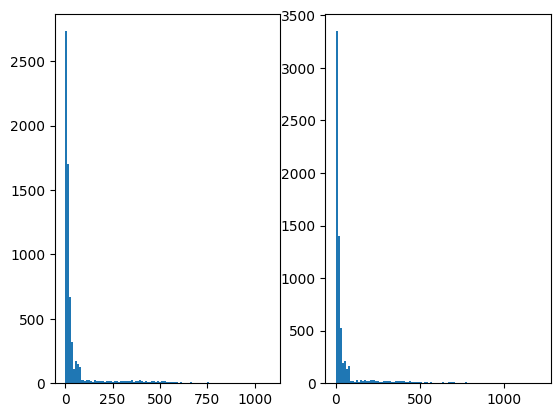

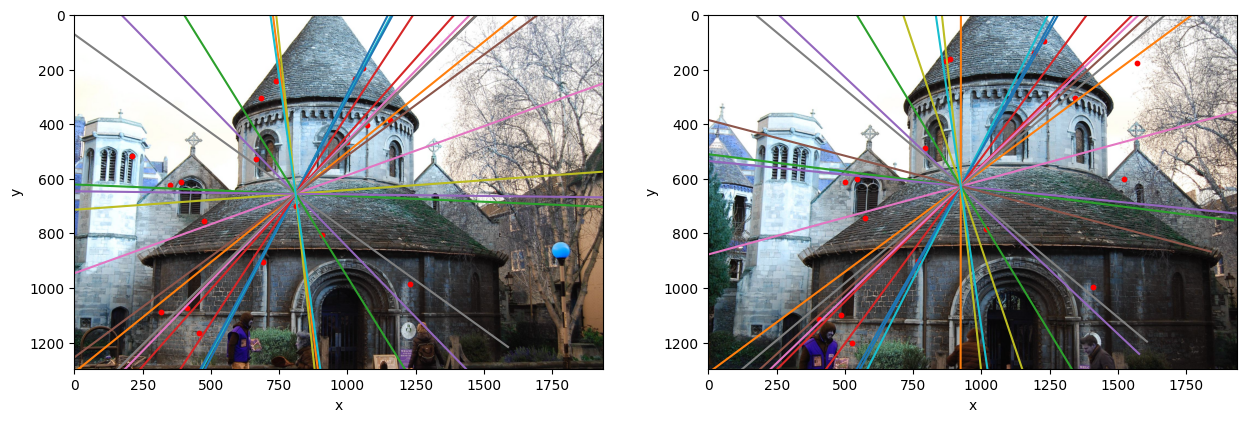

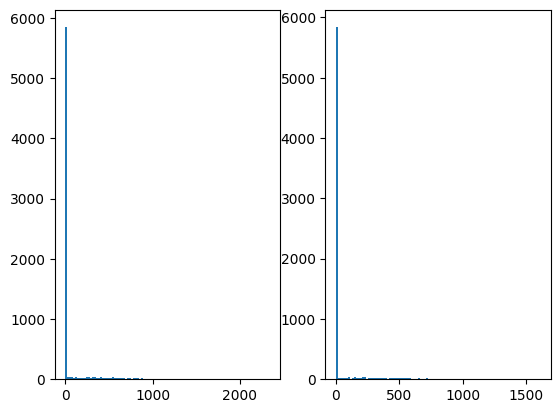

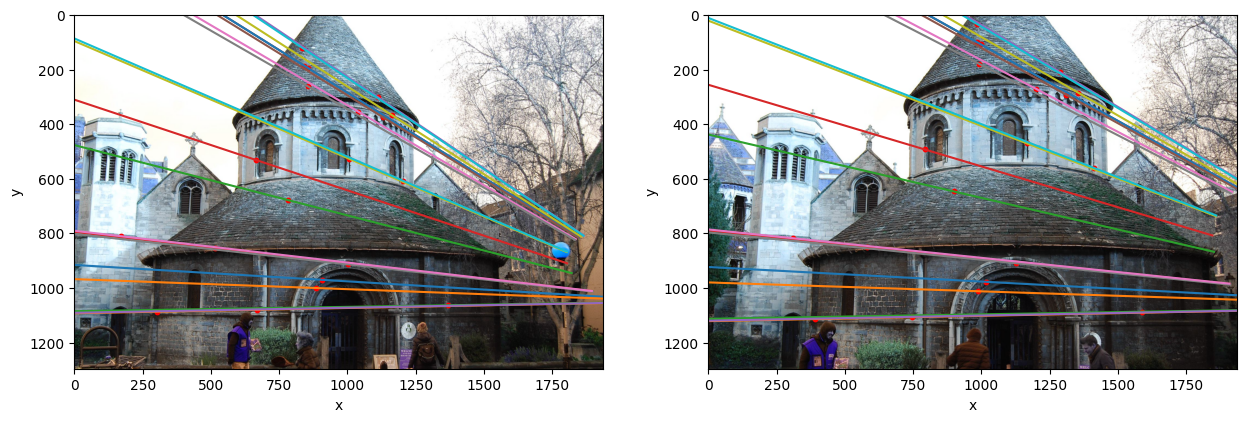

In [40]:
# Computer Exercise 1

def compute_RMS(F: np.ndarray, x1s: np.ndarray, x2s: np.ndarray) -> float:
    ''' Compute the Root Mean Square error between the image points and 
    the corresponding epipolar lines. '''
    n_points = x1s.shape[1]
    dists_1_sq = np.power(utils.compute_epipolar_errors(F, x1s, x2s), 2)
    dists_2_sq = np.power(utils.compute_epipolar_errors(F.T, x2s, x1s), 2)
    error_sq = 1 / (2 * n_points) * (np.sum(dists_1_sq) + np.sum(dists_2_sq))
    return np.sqrt(error_sq)

def estimate_E_robust(x1s: np.ndarray, x2s: np.ndarray, eps: float) -> np.ndarray:
    ''' Estimate E using RANSAC with eps as threshold. 

    Runs the iteration 100 number of times and uses the best estimation.
    Uses 20 samples each iteration.

    Parameters
    ----------
    x1s: np.ndarray
        Image points in image 1
    x2s: np.ndarray:
        Image poitns in image 2
    eps: float
        Threshold to divide points into inliers or outliers
    
    Returns
    -------
    np.ndarray:
        The best estimation of the Essential matrix E
    '''
    N_REPETITIONS = 200
    N_SAMPLES = 10
    best_E = None
    highest_consensus = 0   # The size of the consesus set for the best E
    for _ in range(N_REPETITIONS):
        # Choose points at random
        indices = np.random.choice(x1s.shape[1], N_SAMPLES)
        x1 = x1s[:,indices]
        x2 = x2s[:,indices]
        # Perform 8-point algorithm on them
        E_approx, _, _, _ = utils.estimate_F_DLT(x1, x2)
        E = utils.enforce_essential(E_approx)
        # Compute size of consensus set
        dists = compute_dist_from_E(E, x1s, x2s)
        consensus_indices = dists < (eps ** 2)
        n_consensus = sum(consensus_indices * 1)
        # Update best estimation of E
        if n_consensus > highest_consensus:
            highest_consensus = n_consensus
            best_E = E
    return best_E

def compute_dist_from_E(E: np.ndarray, x1: np.ndarray, x2:np.ndarray) -> float:
    ''' Compute how far all measurement correspondances x1-x2 are from 
    the candidate model for the essential matrix E. '''
    dists_1_sq = np.power(utils.compute_epipolar_errors(E, x1, x2), 2)
    dists_2_sq = np.power(utils.compute_epipolar_errors(E.T, x2, x1), 2)
    return 1/2 * (dists_1_sq + dists_2_sq)

# ----- Load data -----
compEx1data = loadmat(MAT_PATH + 'compEx1data.mat')
K        = compEx1data['K']
x1       = compEx1data['x'][0][0]
x2       = compEx1data['x'][0][1]
church_1 = cv2.imread(IMG_PATH + 'round_church1.jpg')
church_2 = cv2.imread(IMG_PATH + 'round_church2.jpg')
# ---------------------

# Normalize points using K
K_inv = inv(K)
x1_norm = K_inv @ x1
x2_norm = K_inv @ x2

# Compute essential matrix E
E_approx, M, v, sv_min = utils.estimate_F_DLT(x1_norm, x2_norm)
E = utils.enforce_essential(E_approx)

# Convert Essential matrix E to Fundamental matrix F
F = utils.convert_E_to_F(E, K_inv, K_inv)

# Compute epipolar lines
ep_lines_1 = utils.compute_epipolar_lines(F, x1)
ep_lines_2 = utils.compute_epipolar_lines(F.T, x2)

# Compute eRMS
rms = compute_RMS(F, x1, x2)
print(f'The RMS is {round(rms, 4)} (not robust)')

# Plot the distances between points and their corresponding epipolar lines
errors_1 = utils.compute_epipolar_errors(F, x1, x2)
errors_2 = utils.compute_epipolar_errors(F.T, x2, x1)

# Plot epipolar error in a histogram with 100 bins for both images
N_BINS = 100
fig, axs = plt.subplots(1, 2)
axs[0].hist(errors_1, bins=N_BINS)
axs[1].hist(errors_2, bins=N_BINS)

# Pick 20 random points and their respective lines
n_points = 20
indices = np.random.choice(x2.shape[1], n_points)
points_x1 = x1[:,indices]
points_x2 = x2[:,indices]
lines_x1 = ep_lines_2[:, indices]
lines_x2 = ep_lines_1[:, indices]

# Plot points and corresponding epipolar lines with the original images
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
plotter.plot_points_and_lines(axs[0], points_x1, lines_x1, church_1)
plotter.plot_points_and_lines(axs[1], points_x2, lines_x2, church_2)

### Answers: The points seem to be far away from the lines. The problem is most likely due to outliers that push
###          the estimation to be faulty

# Use RANSAC to robustly compute E

# Get error from pixel error by scaling with focal length
inlier_threshold_px = 2
eps = inlier_threshold_px * 2 / (K[0, 0] + K[1, 1])

# Compute the robust E
E = estimate_E_robust(x1_norm, x2_norm, eps)
dists = compute_dist_from_E(E, x1_norm, x2_norm)
inliers_mask = dists < eps ** 2

inliers_x1 = x1[:, inliers_mask]
inliers_x2 = x2[:, inliers_mask]

print(f'The robust essential matrix has {inliers_x1.shape[1]} inliers')

# Compute the RMS 
F = utils.convert_E_to_F(E, K_inv, K_inv)
rms = compute_RMS(F, x1, x2)
print(f'The RMS is {round(rms, 4)} (robust)')

# Plot epipolar error in a histogram with 100 bins for both images
errors_1 = utils.compute_epipolar_errors(F, x1, x2)
errors_2 = utils.compute_epipolar_errors(F.T, x2, x1)

fig, axs = plt.subplots(1, 2)
axs[0].hist(errors_1, bins=N_BINS)
axs[1].hist(errors_2, bins=N_BINS)

# Compute epipolar lines from inliers points
ep_lines_1 = utils.compute_epipolar_lines(F, inliers_x1)
ep_lines_2 = utils.compute_epipolar_lines(F.T, inliers_x2)

# Pick 20 random points and their respective lines
n_points = 20
indices = np.random.choice(inliers_x2.shape[1], n_points)
points_x1 = inliers_x1[:,indices]
points_x2 = inliers_x2[:,indices]
lines_x1 = ep_lines_2[:, indices]
lines_x2 = ep_lines_1[:, indices]

# Plot points and corresponding epipolar lines with the original images
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
plotter.plot_points_and_lines(axs[0], points_x1, lines_x1, church_1)
plotter.plot_points_and_lines(axs[1], points_x2, lines_x2, church_2)

plt.show()

### Comment: the RMS is higher, but the histogram of inliers are much more 
### focused around 0, indicating that the outliers push the rms up.

### Answers: The robust way using RANSAC gives a better estimate since it chooses
### the E which yields the highest number of inliers.

Number of SIFT features found in image 1: 43466
Number of SIFT features found in image 2: 39989
Number of matches: 1700
The robust essential matrix has 1304 inliers
The correct camera for P2 is camera number 1 (of 4)


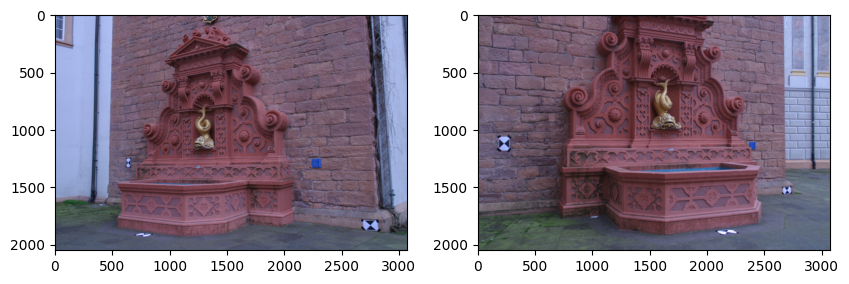

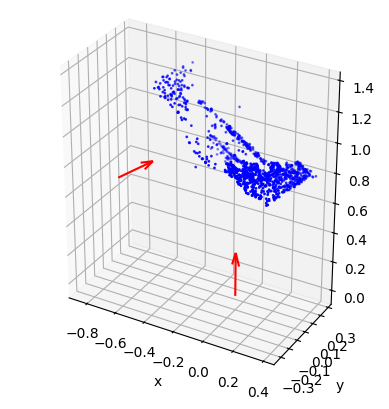

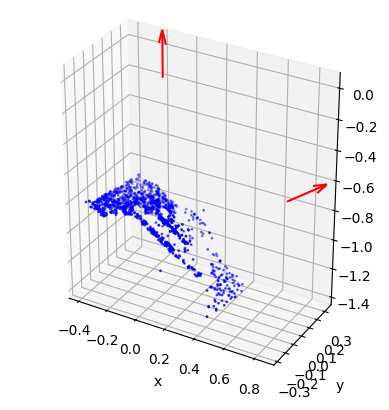

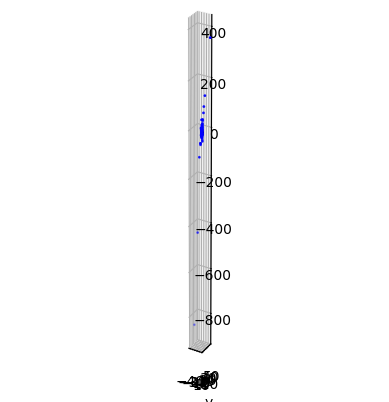

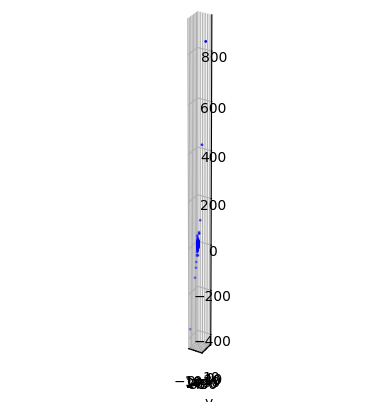

In [41]:
# Computer Exercise 2

def get_best_P2(P1: np.ndarray, P2s: np.ndarray, Xs: np.ndarray) -> tuple:
    ''' Get the best camera P2 and the best set of 3D points.
    
    The best camera is defined as the one with most points in front of
    both cameras (z-coordinate > 1 when projected). 
    
    Parameters
    ----------
    P1: np.ndarray
        The first camera. Most likely the identity camera
    
    P2s: np.ndarray
        An array with all possible camera matrices for the second camera
    
    Xs: np.ndarray
        The triangulated 3D points for each of the possible values of P2

    Returns
    -------
    tuple[np.ndarray, np.ndarray]:
        The best camera P2 and its corresponding triangulated 3D points
    
    '''
    # Determine which set of points X are in front of both cameras (mostly)
    # Do this by projecting onto each camera and count z-indices > 0
    best_index = 0
    P_max = 0
    for i, (X, P2) in enumerate(zip(Xs, P2s)):
        x1_proj = P1_norm @ X
        x2_proj = P2 @ X
        n_front_1 = (x1_proj[2] > 0).sum()
        n_front_2 = (x2_proj[2] > 0).sum()
        if (tot := n_front_1 + n_front_2) > P_max:
            P_max = tot
            best_index = i

    P2_norm = P2s[best_index]
    X = Xs[best_index]
    return (P2_norm, X, best_index)

# ----- Load data -----
compEx2data = loadmat(MAT_PATH + 'compEx2data.mat')
K = compEx2data['K']
K_inv = inv(K)
fountain_1 = cv2.imread(IMG_PATH + 'fountain1.png')
fountain_2 = cv2.imread(IMG_PATH + 'fountain2.png')
# Fix colors of images (convert to RGB-format)
fountain_1 = cv2.cvtColor(fountain_1, cv2.COLOR_BGR2RGB)
fountain_2 = cv2.cvtColor(fountain_2, cv2.COLOR_BGR2RGB)
# Convert images to grayscale
fountain_1_gray = cv2.cvtColor(fountain_1, cv2.COLOR_RGB2GRAY)
fountain_2_gray = cv2.cvtColor(fountain_2, cv2.COLOR_RGB2GRAY)
# ---------------------

# Diplay images
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
axs[0].imshow(fountain_1)
axs[1].imshow(fountain_2)

# Perform SIFT on images
f1, d1 = utils.vl_sift(fountain_1_gray)
f2, d2 = utils.vl_sift(fountain_2_gray)

matches, score = utils.vl_ubcmatch(d1, d2)
x1 = f1[:2, matches[0,:]]
x2 = f2[:2, matches[1,:]]

# Print number of features found in each image and number of matches
print(f'Number of SIFT features found in image 1: {f1.shape[1]}')
print(f'Number of SIFT features found in image 2: {f2.shape[1]}')
print(f'Number of matches: {matches.shape[1]}')

# Plot found features onto the original images
# plotter.plot_points_2D(axs[0], x1, c='b')
# plotter.plot_points_2D(axs[1], x2, c='b')

# Estimate E using RANSAC

# Compute normalized image points
x1 = utils.to_homogeneous(x1)
x2 = utils.to_homogeneous(x2)
x1_norm = K_inv @ x1
x2_norm = K_inv @ x2

# Get error from pixel error by scaling with focal length
inlier_threshold_px = 2
eps = inlier_threshold_px * 2 / (K[0, 0] + K[1, 1])

# Compute the robust E
E = estimate_E_robust(x1_norm, x2_norm, eps)

# Get inliers
dists = compute_dist_from_E(E, x1_norm, x2_norm)
inliers_mask = dists < eps ** 2
inliers_x1 = x1[:, inliers_mask]
inliers_x2 = x2[:, inliers_mask]
print(f'The robust essential matrix has {inliers_x1.shape[1]} inliers')

# Convert to F
# F = utils.convert_E_to_F(E, K_inv, K_inv)

# Find all 4 possible camera matrix pairs for the essential matrix
P2s = utils.extract_P_from_E(E)
P2s = np.array([K @ P2 for P2 in P2s])
P1_norm = np.eye(3, 4)
P1 = K @ P1_norm

# Triangulate points for each of the camera matrices P2
Xs = np.array([utils.triangulate_3D_point_DLT(inliers_x1, inliers_x2, P1, P2) for P2 in P2s])

# Plot all possible camera matrices and their corresponding triangulated 3D points
c1, axis1 = utils.camera_center_and_axis(P1)
for P2, X in zip(P2s, Xs):
    fig_3D = plt.figure()
    ax_3D = fig_3D.add_subplot(projection='3d')
    c2, axis2 = utils.camera_center_and_axis(P2)
    plotter.plot_camera(ax_3D, c1, axis1, 0.3)
    plotter.plot_camera(ax_3D, c2, axis2, 0.3)
    plotter.plot_points_3D(ax_3D, X, c='b')

# Get the correct P2 and triangulated 3D points for that camera
P2, X, P2_index = get_best_P2(P1_norm, P2s, Xs)
X = utils.pflat(X)
print(f'The correct camera for P2 is camera number {P2_index + 1} (of {len(P2s)})')

### Answers: The correct camera seem to be number 3 of 4. This is also confirmed by 
### choosing the camera with the most points in front of both cameras

plt.show()

The sum of errors for the non-refined 3D points is 22354.24
The sum of errors for the refined 3D points is 22072.3
The median error for non-refined 3D points is 11.66
The median error for refined 3D points is 11.55


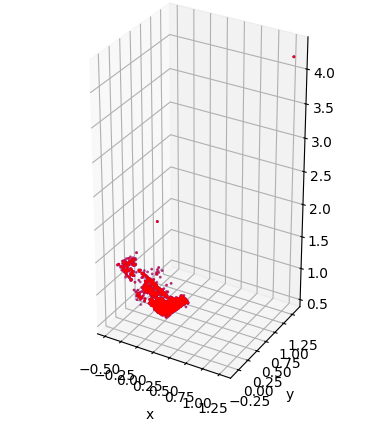

In [ ]:
# Computer Exercise 3
# Loop over 3D points and improve them using Levenberg-Marquardt

def compute_reprojection_error(P1: np.ndarray, P2: np.ndarray, Xj: np.ndarray, x1j: np.ndarray, x2j: np.ndarray) -> tuple:
    ''' Computes the reprojection error given two cameras, a 3D point and 2D points
    for the two cameras. 
    
    Computes the reprojection error according to: ...

    Parameters
    ----------
    P1: np.ndarray
        Camera 1
    
    P2: np.ndarray
        Camera 2

    Xj: np.ndarray
        The 3D points
    
    x1j: np.ndarray
        The image points of the 3D points, corresponding to Camera 1
    
    x2j: np.ndarray
        The image points of the 3D points, corresponding to Camera 1

    Returns
    -------
    tuple[float, np.ndarray]:
        A tuple consisting of the reprojection error and the residual vector r(Xj)

    '''
    r_inner, _ = linearize_reprojection_error(P1, P2, Xj, x1j, x2j)
    r1 = r_inner[:2]
    r2 = r_inner[2:4]
    # err = np.linalg.norm(r_inner)# 
    err = np.linalg.norm(r1) ** 2 + np.linalg.norm(r2) ** 2
    return err, r_inner

def linearize_reprojection_error(P1, P2, Xj, x1j, x2j) -> tuple:
    ''' Computes the linearization r and J. '''
    # Setup r
    r1 = np.array([
        x1j[0] - (P1[0] @ Xj) / (P1[2] @ Xj), 
        x1j[1] - (P1[1] @ Xj) / (P1[2] @ Xj)
    ])
    r2 = np.array([
        x2j[0] - (P2[0] @ Xj) / (P2[2] @ Xj), 
        x2j[1] - (P2[1] @ Xj) / (P2[2] @ Xj)
    ])
    r_tmp = np.hstack([r1, r2]).reshape(-1, 1)
    # Setup J
    denom1 = np.power(P1[2] @ Xj, 2)
    J1 = np.hstack([
        ((P1[0] @ Xj) / denom1 * P1[2] - (1 / (P1[2] @ Xj)) * P1[0]).reshape(-1, 1),
        ((P1[1] @ Xj) / denom1 * P1[2] - (P1[1] / (P1[2] @ Xj)) * P1[1]).reshape(-1, 1)
    ])
    denom2 = np.power(P2[2] @ Xj, 2)
    J2 = np.hstack([
        ((P2[0] @ Xj) / denom2 * P2[2] - P2[0] / (P2[2] @ Xj)).reshape(-1, 1),
        ((P2[1] @ Xj) / denom2 * P2[2] - P2[1] / (P2[2] @ Xj)).reshape(-1, 1)
    ])
    J_tmp = np.hstack([J1, J2])
    return (r_tmp, J_tmp)

def compute_update(r: np.ndarray, J: np.ndarray, mu: float) -> np.ndarray:
    ''' Computes the LM-update given vectors r and J. '''
    deltaXj = -inv(J.T @ J + mu * np.identity(J.shape[1])) @ (J.T @ r)
    return deltaXj

def iterate_point(P1, P2, Xj, x1j, x2j, mu):
    EPS = 0.000001
    err_prev, _ = compute_reprojection_error(P1, P2, Xj, x1j, x2j)
    # best_Xj = Xj.copy().reshape(-1, 1)
    # while (err_prev > EPS):
    for i in range(100):
        r, J = linearize_reprojection_error(P1, P2, Xj, x1j, x2j)
        dXj = compute_update(r, J, mu)
        new_Xj = utils.pflat(Xj + J @ dXj)
        # new_Xj = utils.pflat(best_Xj + dXj)
        err, _ = compute_reprojection_error(P1, P2, new_Xj, x1j, x2j)
        err_old, _ = compute_reprojection_error(P1, P2, Xj, x1j, x2j)
        if err <= err_old:
            Xj = new_Xj
            mu /= 10
        else:
            mu *= 10
    return Xj

# ------ Load data -------
compEx3data = loadmat(MAT_PATH + 'compEx3data.mat')
K = compEx3data['K']
P1 = compEx3data['P'][0][0]
P2 = compEx3data['P'][0][1]
X = compEx3data['X']
inliers_x1 = compEx3data['x'][0][0]
inliers_x2 = compEx3data['x'][0][1]
# ------------------------

n_points = X.shape[1]
errors_initial = [compute_reprojection_error(P1, P2, X[:,i], inliers_x1[:,i], inliers_x2[:,i])[0] for i in range(n_points)]
tot_error_initial = sum(errors_initial)
X_old = np.copy(X)

# Iterate each of the 3D points and improve it
X_improved = np.zeros_like(X)
for i in range(n_points):
    mu = 0.1
    new_Xj = iterate_point(P1, P2, X[:,i].reshape(-1, 1), inliers_x1[:,i], inliers_x2[:,i], mu)
    X_improved[:,i] = new_Xj[:,0]

# Compare reprojection errors for initial and improved points
errors_improved = [compute_reprojection_error(P1, P2, X_improved[:,i], inliers_x1[:,i], inliers_x2[:,i])[0] for i in range(n_points)]
tot_error_improved = sum(errors_improved)

# Print sum of errors and median of errors
print(f'The sum of errors for the non-refined 3D points is {np.round(tot_error_initial, 2)}')
print(f'The sum of errors for the refined 3D points is {np.round(tot_error_improved, 2)}')
median_inital = np.median(errors_initial)
median_improved = np.median(errors_improved)
print(f'The median error for non-refined 3D points is {np.round(median_inital, 2)}')
print(f'The median error for refined 3D points is {np.round(median_improved, 2)}')

# Plot both original and refined 3D points in the same plot
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.view_init(elev=40, azim=-47, roll=0)
plotter.plot_points_3D(ax_3D, X, c='b')
plotter.plot_points_3D(ax_3D, X_improved, c='r')

plt.show()